# Introduction to OpenTURNS objects

In the otbenchmark package, we use several objects that must be known in order to distinguish which objects com from the OpenTURNS library or from otbenchmark.
For reliability problems, there are three objects that cannot be ignored:
* the `Distribution`,
* the `Function`,
* the `ThresholdEvent`.

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb
import pandas as pd
import matplotlib.pyplot as plt
import openturns.viewer as otv

## Distribution

In [2]:
# Define two marginals
X0 = ot.Normal(0.0, 1.0)
X1 = ot.Uniform(0.0, 1.0)
# Define an independent joint distribution
X_ind = ot.ComposedDistribution([X0, X1])
# Define a dependent joint distribution using a copula (e.g., Frank copula)
copula = ot.FrankCopula(5)
X_dep = ot.ComposedDistribution([X0, X1], copula)
# Generate a sample of each joint distribution
X_ind_sample = X_ind.getSample(1000)
X_dep_sample = X_dep.getSample(1000)

In [3]:
method_list = [method for method in dir(X0) if method.startswith("__") is False]
print(len(method_list))

144


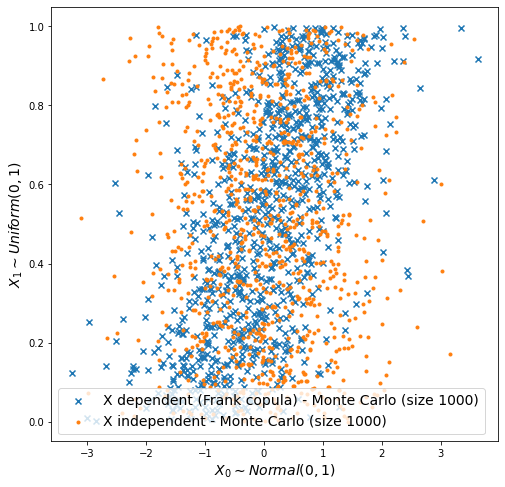

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(
    X_dep_sample[:, 0],
    X_dep_sample[:, 1],
    label="X dependent (Frank copula) - Monte Carlo (size 1000)",
    marker="x",
)
plt.scatter(
    X_ind_sample[:, 0],
    X_ind_sample[:, 1],
    label="X independent - Monte Carlo (size 1000)",
    marker=".",
)

plt.xlabel("$X_0 \sim Normal(0, 1)$", fontsize=14)
plt.ylabel("$X_1 \sim Uniform(0, 1)$", fontsize=14)
_ = plt.legend(loc="best", fontsize=14)

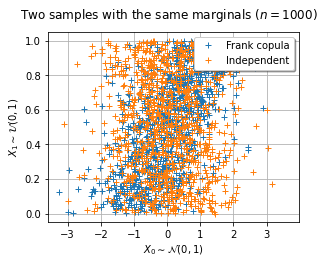

In [5]:
graph = ot.Graph(
    "Two samples with the same marginals ($n=1000$)",
    r"$X_0 \sim \mathcal{N}(0, 1)$",
    r"$X_1 \sim \mathcal{U}(0, 1)$",
    True,
)
cloud = ot.Cloud(X_dep_sample[:, 0], X_dep_sample[:, 1])
cloud.setLegend("Frank copula")
graph.add(cloud)
cloud = ot.Cloud(X_ind_sample[:, 0], X_ind_sample[:, 1])
cloud.setLegend("Independent")
graph.add(cloud)
graph.setLegendPosition("topright")
graph.setColors(ot.Drawable_BuildDefaultPalette(2))
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("two_samples.pdf")

## Function

In [6]:
# Define a symbolic function
myfunction = ot.SymbolicFunction(["x0", "x1"], ["sin(x0) * (1 + x1 ^ 2)"])
myfunction.setInputDescription(["$x_0$", "$x_1$"])
myfunction.setOutputDescription(["$y$"])
# Define input random vectors
inputVect_ind = ot.RandomVector(X_ind)
inputVect_dep = ot.RandomVector(X_dep)
# Compose input random vectors by the symbolic function
outputVect_ind = ot.CompositeRandomVector(myfunction, inputVect_ind)
outputVect_dep = ot.CompositeRandomVector(myfunction, inputVect_dep)
# Sample the output random variable
outputSample_ind = outputVect_ind.getSample(10000)
outputSample_dep = outputVect_dep.getSample(10000)

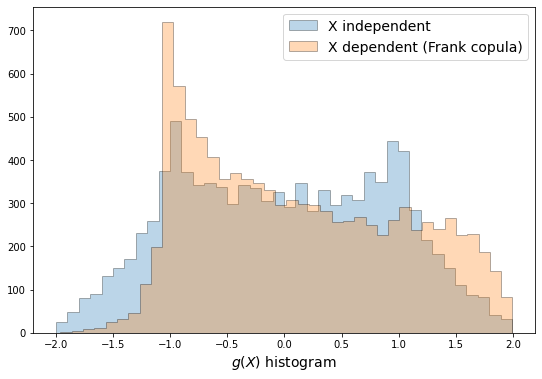

In [7]:
plt.figure(figsize=(9, 6))
plt.hist(
    outputSample_ind,
    bins=40,
    histtype="stepfilled",
    alpha=0.3,
    ec="k",
    label="X independent",
)
plt.hist(
    outputSample_dep,
    bins=40,
    histtype="stepfilled",
    alpha=0.3,
    ec="k",
    label="X dependent (Frank copula)",
)
plt.xlabel("$g(X)$ histogram", fontsize=14)
_ = plt.legend(loc="best", fontsize=14)

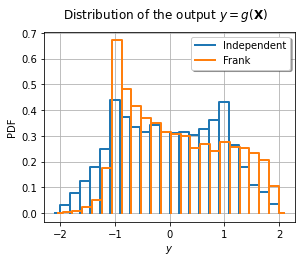

In [8]:
graph = ot.HistogramFactory().build(outputSample_ind).drawPDF()
graph.setLegends(["Independent"])
graph.setTitle("Distribution of the output $y=g(\mathbf{X})$")
curve = ot.HistogramFactory().build(outputSample_dep).drawPDF()
curve.setLegends(["Frank"])
graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(2))
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("histo_output.pdf")

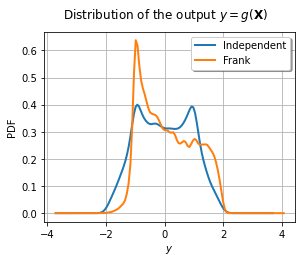

In [9]:
graph = ot.KernelSmoothing().build(outputSample_ind).drawPDF()
graph.setLegends(["Independent"])
graph.setTitle("Distribution of the output $y=g(\mathbf{X})$")
curve = ot.KernelSmoothing().build(outputSample_dep).drawPDF()
curve.setLegends(["Frank"])
graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(2))
view = otv.View(graph, figure_kw={"figsize": (4.5, 3.5)})
view.save("kernel_output.pdf")

## ThresholdEvent

In [10]:
threshold = 1.0  # Change this to 2.0 to turn it into a difficult problem
event = ot.ThresholdEvent(outputVect_ind, ot.Greater(), threshold)
event

class=ThresholdEventImplementation antecedent=class=CompositeRandomVector function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[$x_0$,$x_1$,$y$] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x0,x1] outputVariablesNames=[y0] formulas=[sin(x0) * (1 + x1 ^ 2)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x0,x1] outputVariablesNames=[y0] formulas=[sin(x0) * (1 + x1 ^ 2)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x0,x1] outputVariablesNames=[y0] formulas=[sin(x0) * (1 + x1 ^ 2)] antecedent=class=UsualRandomVector distribution=class=ComposedDistribution name=ComposedDistribution dimension=2 copula=class=IndependentCopula name=IndependentCopula dimension=2 marginal[0]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[1]=class=Uniform name=Uniform dimension=1 a=0 b=1 operator=class=Greater name=Unnamed threshold=1

In [11]:
maximumCoV = 0.05  # Coefficient of variation
maximumNumberOfBlocks = 100000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(event, experiment)
algoMC.setMaximumOuterSampling(maximumNumberOfBlocks)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(maximumCoV)

In [12]:
algoMC.run()

In [13]:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
print("Pf = ", probability)

Pf =  0.17311715481171547
